서울시 열린데이터 https://data.seoul.go.kr/ 에서 제공하는 ```서울특별시_공공자전거 일별 대여건수_(2018~2019.03).csv```를 분석해보자.

파일은 웹 검색을 하고 다운로드해서 사용하면 된다.

-> 구글링 https://data.seoul.go.kr/dataList/OA-14994/F/1/datasetView.do#

데이터는 일자별로, 대여건수이이고, 몇 줄만 출력해보면 다음과 같다.



|      date| count|

|----------|------|

|2018-01-01|  4950|

|2018-01-02|  7136|

|2018-01-03|  7156|

|2018-01-04|  7102|

|2018-01-05|  7705|

* 제출: ipynb 파일 1개 (zip하지 마세요), 파일첨부 필요하지 않아요.

# 데이터 및 모듈 세팅

In [3]:
import os
import pyspark

sparkConfig = pyspark.SparkConf()

spark = pyspark.sql.SparkSession.builder\
    .master('local')\
    .appName('app')\
    .config(conf=sparkConfig)\
    .getOrCreate()

In [4]:
from pyspark.sql.types import *

schema=StructType([
    StructField("date", DateType(), True),
    StructField("count", IntegerType(), True),
])

_bicycle = spark.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true')\
    .schema(schema)\
    .load('data/서울특별시_공공자전거 일별 대여건수_(2018_2019.03).csv')

In [5]:
_bicycle.printSchema()

root
 |-- date: date (nullable = true)
 |-- count: integer (nullable = true)



In [6]:
_bicycle.count()

455

In [7]:
_bicycle.show(5)

+----------+-----+
|      date|count|
+----------+-----+
|2018-01-01| 4950|
|2018-01-02| 7136|
|2018-01-03| 7156|
|2018-01-04| 7102|
|2018-01-05| 7705|
+----------+-----+
only showing top 5 rows



In [21]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def classfiyQuarter(s):
    q=""
    if 1<=s and s< 4:
        q="Q1"
    elif 4<=s and s< 7:
        q="Q2"
    elif 7<=s and s< 10:
        q="Q3"
    elif 10<=s and s<= 12:
        q="Q4"
    else:
        q=no
    return q
    
quarter_udf = udf(classfiyQuarter, StringType())

# 문제 1-1: 년도별 대여건수 합계

데이터는 2018, 2019년 15개월 간의 대여건수이다. 년도별로 대여건수의 합계를 계산해서 출력하자.



|year|sum(count)|

|----|----------|

|2018|  10124874|

|2019|   1871935|

In [8]:
# Rdd 를 이용한 방법
rddResult = _bicycle.rdd\
    .map(lambda x: (str(x[0]).split("-")[0], x[1]))\
    .reduceByKey(lambda x, y: x + y)\
    .collect()
    
rddResult

[('2018', 10124874), ('2019', 1871935)]

In [9]:
_bicycle.take(5)

[Row(date=datetime.date(2018, 1, 1), count=4950),
 Row(date=datetime.date(2018, 1, 2), count=7136),
 Row(date=datetime.date(2018, 1, 3), count=7156),
 Row(date=datetime.date(2018, 1, 4), count=7102),
 Row(date=datetime.date(2018, 1, 5), count=7705)]

In [10]:
from pyspark.sql.functions import to_date, col, year, sum
# from pyspark.sql import functions as F

# Dataframe 을 이용한 방법

bicycleDataFrame = _bicycle\
.withColumn("formattedDate", to_date(col("date"), "yyyy-MM-d"))\
.withColumn('year', year("date"))

bicycleDataFrame.take(5)

[Row(date=datetime.date(2018, 1, 1), count=4950, formattedDate=datetime.date(2018, 1, 1), year=2018),
 Row(date=datetime.date(2018, 1, 2), count=7136, formattedDate=datetime.date(2018, 1, 2), year=2018),
 Row(date=datetime.date(2018, 1, 3), count=7156, formattedDate=datetime.date(2018, 1, 3), year=2018),
 Row(date=datetime.date(2018, 1, 4), count=7102, formattedDate=datetime.date(2018, 1, 4), year=2018),
 Row(date=datetime.date(2018, 1, 5), count=7705, formattedDate=datetime.date(2018, 1, 5), year=2018)]

In [11]:
bicycleDataFrame\
.groupBy("year")\
.agg({"count": "sum"})\
.orderBy("year")\
.show()

# bicycleDataFrame\
# .groupBy("year")\
# .agg(sum('count'))\
# .orderBy("year")
# .show()

+----+----------+
|year|sum(count)|
+----+----------+
|2018|  10124874|
|2019|   1871935|
+----+----------+



# 문제 1-2: 년도별, 월별 대여건수 합계

년별, 월별로 대여건수를 계산하여 합계를 계산하여 출력한다.


In [22]:
from pyspark.sql import functions as F

bicycleDataFrame2 = _bicycle\
.withColumn("formattedDate", F.to_date(F.col("date"), "yyyy-MM-d"))\
.withColumn('year', year("date"))\
.withColumn('month', F.month("date"))\
.withColumn('year/month', F.date_format(F.col("date") ,"yyyy-MM"))


bicycleDataFrame2 = bicycleDataFrame2.withColumn('quarter', quarter_udf("month"))\

bicycleDataFrame2.printSchema()

root
 |-- date: date (nullable = true)
 |-- count: integer (nullable = true)
 |-- formattedDate: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year/month: string (nullable = true)
 |-- quarter: string (nullable = true)



In [25]:
bicycleDataFrame2.groupBy("quarter").count().orderBy("quarter").show()

+-------+-----+
|quarter|count|
+-------+-----+
|     Q1|  180|
|     Q2|   91|
|     Q3|   92|
|     Q4|   92|
+-------+-----+



In [28]:
bicycleDataFrame2.groupBy("quarter").count().orderBy("quarter").show()

+-------+-----+
|quarter|count|
+-------+-----+
|     Q1|  180|
|     Q2|   91|
|     Q3|   92|
|     Q4|   92|
+-------+-----+



In [23]:
bicycleDataFrame2.take(5)

[Row(date=datetime.date(2018, 1, 1), count=4950, formattedDate=datetime.date(2018, 1, 1), year=2018, month=1, year/month='2018-01', quarter='Q1'),
 Row(date=datetime.date(2018, 1, 2), count=7136, formattedDate=datetime.date(2018, 1, 2), year=2018, month=1, year/month='2018-01', quarter='Q1'),
 Row(date=datetime.date(2018, 1, 3), count=7156, formattedDate=datetime.date(2018, 1, 3), year=2018, month=1, year/month='2018-01', quarter='Q1'),
 Row(date=datetime.date(2018, 1, 4), count=7102, formattedDate=datetime.date(2018, 1, 4), year=2018, month=1, year/month='2018-01', quarter='Q1'),
 Row(date=datetime.date(2018, 1, 5), count=7705, formattedDate=datetime.date(2018, 1, 5), year=2018, month=1, year/month='2018-01', quarter='Q1')]

In [30]:
bicycleGroupByYearMonthDF = bicycleDataFrame2\
.groupBy("year/month")\
.agg({"count": "sum"})\
.orderBy("year/month")

bicycleGroupByYearMonthDF.show()

+----------+----------+
|year/month|sum(count)|
+----------+----------+
|   2018-01|    164367|
|   2018-02|    168741|
|   2018-03|    462661|
|   2018-04|    687885|
|   2018-05|    965609|
|   2018-06|   1207123|
|   2018-07|   1100015|
|   2018-08|   1037505|
|   2018-09|   1447993|
|   2018-10|   1420621|
|   2018-11|    961532|
|   2018-12|    500822|
|   2019-01|    495573|
|   2019-02|    471543|
|   2019-03|    904819|
+----------+----------+



# 정답은 피봇해야함

In [31]:
bicycleGroupByYearMonthDF2 = bicycleDataFrame2\
.groupBy("year")\
.pivot("month")\
.agg({"count": "sum"})

bicycleGroupByYearMonthDF2.show()

+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+
|year|     1|     2|     3|     4|     5|      6|      7|      8|      9|     10|    11|    12|
+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+
|2018|164367|168741|462661|687885|965609|1207123|1100015|1037505|1447993|1420621|961532|500822|
|2019|495573|471543|904819|  null|  null|   null|   null|   null|   null|   null|  null|  null|
+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+



In [33]:
import pandas as pd
import numpy as np

bicycleP = bicycleDataFrame2.toPandas()

In [34]:
bicycleP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           455 non-null    object
 1   count          455 non-null    int32 
 2   formattedDate  455 non-null    object
 3   year           455 non-null    int32 
 4   month          455 non-null    int32 
 5   year/month     455 non-null    object
 6   quarter        455 non-null    object
dtypes: int32(3), object(4)
memory usage: 19.7+ KB


In [35]:
bicycleP.groupby('year').aggregate({"count": "sum"})

,count
year,
2018,10124874
2019,1871935


In [36]:
# 행 
pd.pivot_table(bicycleP, values = 'count', index = ['year'], columns = ['month'], aggfunc= 'sum')

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2018,164367.0,168741.0,462661.0,687885.0,965609.0,1207123.0,1100015.0,1037505.0,1447993.0,1420621.0,961532.0,500822.0
2019,495573.0,471543.0,904819.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
bicycleP2018 = bicycleP[bicycleP['year']==2018]

In [44]:
bicycleP2018byQ = pd.pivot_table(bicycleP, values = 'count', index = ['year'], columns = ['quarter'], aggfunc= 'sum')

In [45]:
bicycleP2018byQ.iloc[:, 0:4]

quarter,Q1,Q2,Q3,Q4
year,,,,
2018,795769.0,2860617.0,3585513.0,2882975.0
2019,1871935.0,NaN,NaN,NaN


# 분기 추출

# 문제 1-3: 년도별, 월별 대여건수 그래프

문제 1-2의 출력을 선 그래프로 그려보자.


In [49]:

bicycleDataFrame3 = _bicycle\
.withColumn("formattedDate", F.to_date(F.col("date"), "yyyy-MM-d"))\
.withColumn('year', year("date"))\
.withColumn('month', F.month("date"))\
.withColumn('year/month', F.date_format(F.col("date") ,"yyyy-MM"))


bicycleDataFrame3 = bicycleDataFrame2.withColumn('quarter', quarter_udf("month"))\


sumMonthly = bicycleDataFrame3.groupBy('year').pivot('month').agg({'count': 'sum'})

In [50]:
pdf = sumMonthly.toPandas()

In [51]:
pdf.head()

,year,1,2,3,4,5,6,7,8,9,10,11,12
0,2018,164367,168741,462661,687885.0,965609.0,1207123.0,1100015.0,1037505.0,1447993.0,1420621.0,961532.0,500822.0
1,2019,495573,471543,904819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# transpose 바꾸어 놓다
# drop
my = pdf.drop('year', 1).transpose()

In [54]:
my

,0,1
1,164367.0,495573.0
2,168741.0,471543.0
3,462661.0,904819.0
4,687885.0,NaN
5,965609.0,NaN
6,1207123.0,NaN
7,1100015.0,NaN
8,1037505.0,NaN
9,1447993.0,NaN
10,1420621.0,NaN


<AxesSubplot:>

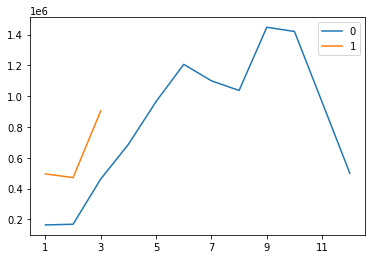

In [55]:
my.plot(kind='line')

In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt



In [ ]:
import numpy as np


In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

_dateRdd=bicycleGroupByYearMonthDF.rdd.map(lambda fields: fields[0]).collect()
_sumRdd=bicycleGroupByYearMonthDF.rdd.map(lambda fields: fields[1]).collect()

# Get the cuirrenct 
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)

# Get the current axis
ax = plt.gca()

# Now set the ticks and labels
# ax.set_xticks(_sumRdd)
# ax.set_xticklabels(_sumRdd)

plt.plot(np.array(_dateRdd), np.array(_sumRdd))
plt.show()